<div style="text-align: center;">
  <h1>Transaction Success Rate Prediction</h1>
  <h2>Real-Time Transaction Routing Strategy Optimization</h2>
  <img src="imgs/3937443.jpg" alt="Transaction Analysis Overview" width="1000" height="500"/>
  <p>
    <a href="http://www.freepik.com">Freepik</a>
  </p>
</div>



### Author: Umar Kabir
#### Date: March 17, 2025

### Introduction
This notebook develops, optimizes, and validates a real-time transaction routing strategy based on predictive models. We'll implement adaptive routing algorithms to dynamically adjust payment processor selection and improve transaction success rates. The primary objective is to optimize payment routing by selecting the processor with the highest predicted success probability in real-time.

<a id="home"></a>

### Table of Contents
1. [Load & Prepare Data](#1)
2. [Develop Real-Time Routing Logic](#2)
3. [Implement Multi-Armed Bandit (MAB) Algorithm](#3)
4. [Reinforcement Learning (RL)-Based Routing](#4)
5. [Test & Simulate Routing Strategies](#5)
6. [Performance Evaluation & Final Recommendations](#6)
7. [Summary and Conclusions](#7)

In [1]:
import sys
import os

# Get the absolute path of the parent directory
sys.path.insert(0, os.path.abspath('../'))

# import the necessary packages
from src.dependencies import *
from src.utils import *

c:\Users\USER\Documents\Documents\Personal Development\Portfolio Projects\transaction_success_optimization\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id="1"></a>
## 1. Load & Prepare Data  

[Back to Top](#home)

### Load transaction dataset with model predictions

In [2]:
# Load dataset
try:
    df = pd.read_csv('../data/processed/full_feature_engineered_data.csv')
    print(f"Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print("Transaction data file not found. Try changing directory.")

Successfully loaded dataset with 5463 rows and 70 columns.


In [3]:
# Get unique processor IDs
processor_names = df['processor_id'].unique()

# Ensure processor_success_rates is mapped correctly from df
processor_success_rates = df.set_index('processor_id')['processor_success_rate'].to_dict()

# Generate predicted success probability for each processor
for processor in processor_names:
    df[f'{processor}_predicted_success'] = df.apply(
        lambda row: max(0, min(1, processor_success_rates.get(processor, 0) + 
                                0.05 * (row['merchant_success_rate'] - 0.85) + 
                                0.03 * (row['payment_method_rolling_success'] - 0.85) - 
                                0.04 * (row['latency_bin_encoded'] / 4) +
                                random.uniform(-0.05, 0.05))),
        axis=1
    )

# Determine the best processor for each transaction
processor_cols = [f'{processor}_predicted_success' for processor in processor_names]
df['best_processor'] = df[processor_cols].idxmax(axis=1).str.replace('_predicted_success', '')

# Track if the actual processor was the best choice
df['optimal_processor_selected'] = (df['processor_id'] == df['best_processor']).astype(int)

# Cleanup
df.reset_index(drop=True, inplace=True)

# Display the updated DataFrame
display(df.head())

,transaction_id,timestamp,merchant_id,customer_id,customer_location,payment_amount,payment_method,device_type,network_latency,result,processor_id,time_of_day,day_of_week,error_code,failure_reason,retry_count,regional_event,amount_bin,merchant_transaction_count,result_numeric,merchant_success_rate,merchant_rolling_avg_amount,hour,day_name,month,is_weekend,hourly_transaction_volume,hourly_success_rate,is_peak_hour,payment_method_rolling_success,processor_success_rate,device_success_rate,latency_bin,latency_bin_success_rate_x,has_retry,latency_bin_success_rate_y,latency_bin_success_rate,location_success_rate,payment_location_success_rate,payment_method_bank_transfer,payment_method_credit_card,payment_method_debit_card,payment_method_mobile_money,payment_method_ussd,device_type_atm,device_type_mobile,device_type_pos,device_type_web,time_of_day_night,time_of_day_morning,time_of_day_afternoon,time_of_day_evening,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,amount_bin_encoded,latency_bin_encoded,network_latency_scaled,merchant_rolling_avg_amount_scaled,merchant_success_rate_scaled,device_success_rate_scaled,payment_method_rolling_success_scaled,location_success_rate_scaled,payment_location_success_rate_scaled,merchant_transaction_count_log,hourly_transaction_volume_log,proc001_predicted_success,proc005_predicted_success,proc002_predicted_success,proc003_predicted_success,proc004_predicted_success,best_processor,optimal_processor_selected
0,500399ad-7770-4e89-bebe-ae7ce7b4fc02,2023-03-01 10:15:25,MERCH00045,CUST000629,urban,16.33,bank_transfer,web,121.33,success,proc001,morning,2,no_error,no_failure,0,no_event,low,48,1,0.979167,15.3300,10,Wednesday,3,0,338,0.943787,1,NaN,0.948933,0.947093,high,0.935531,0,0.935531,0.935531,0.937692,0.952830,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,2,3,0.165873,0.031360,0.851562,1.0,NaN,0.98617,0.710078,3.891820,5.826000,1.000000,1.000000,1.000000,1.000000,1.000000,proc001,1
1,62b96b0b-f757-4bef-99b8-7592d3305637,2023-03-01 13:19:24,MERCH00047,CUST000849,urban,8.53,bank_transfer,mobile,56.36,success,proc005,afternoon,2,no_error,no_failure,0,no_event,very_low,48,1,0.937500,25.2350,13,Wednesday,3,0,306,0.954248,0,NaN,0.921260,0.926793,medium,0.930454,0,0.930454,0.930454,0.937692,0.952830,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,1,2,-0.551120,0.055035,0.554688,0.0,NaN,0.98617,0.710078,3.891820,5.726848,1.000000,1.000000,1.000000,1.000000,1.000000,proc001,0
2,82e6eacc-7f94-49a8-b47f-075b6ddeaa1a,2023-03-01 14:14:33,MERCH00017,CUST000751,suburban,7.24,bank_transfer,web,56.45,success,proc002,afternoon,2,no_error,no_failure,0,no_event,very_low,46,1,1.000000,14.7700,14,Wednesday,3,0,359,0.935933,1,NaN,0.951515,0.947093,medium,0.930454,0,0.930454,0.930454,0.937921,0.978261,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,1,2,-0.550127,0.030021,1.000000,1.0,NaN,1.00000,0.866384,3.850148,5.886104,1.000000,1.000000,1.000000,1.000000,1.000000,proc001,0
3,0c53cb08-3f45-43bb-b437-bbe9cc52ff0f,2023-03-01 14:22:34,MERCH00073,CUST000868,urban,23.61,bank_transfer,web,151.11,success,proc003,afternoon,2,no_error,no_failure,0,no_event,low,58,1,0.931034,58.2675,14,Wednesday,3,0,359,0.935933,1,NaN,0.916168,0.947093,very_high,0.929722,0,0.929722,0.929722,0.937692,0.952830,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,2,4,0.494518,0.133990,0.508621,1.0,NaN,0.98617,0.710078,4.077537,5.886104,1.000000,1.000000,1.000000,1.000000,1.000000,proc001,0
4,24e14a9b-91ff-459e-820a-4ece0a28a722,2023-03-02 05:41:33,MERCH00009,CUST000062,rural,25.40,bank_transfer,web,186.90,success,proc005,night,3,no_error,no_failure,0,no_event,low,51,1,0.960784,25.4000,5,Thursday,3,0,176,0.914773,0,1.0,

In [4]:
# Display basic information about the dataset
print("\nDataset Information:")
print(f"Number of transactions: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Overall success rate: {df['result_numeric'].mean():.4f}")
print(f"Number of unique processors: {df['processor_id'].nunique()}")

# Examine processor success rates
processor_success = df.groupby('processor_id')['result_numeric'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print("\nProcessor Success Rates:")
print(processor_success)

# Examine payment method success rates
payment_success = df.groupby('payment_method')['result_numeric'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print("\nPayment Method Success Rates:")
print(payment_success)

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f"\nTraining set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

# Prepare data for routing simulation
simulation_data = test_df.reset_index(drop=True)


Dataset Information:
Number of transactions: 5463
Columns: ['transaction_id', 'timestamp', 'merchant_id', 'customer_id', 'customer_location', 'payment_amount', 'payment_method', 'device_type', 'network_latency', 'result', 'processor_id', 'time_of_day', 'day_of_week', 'error_code', 'failure_reason', 'retry_count', 'regional_event', 'amount_bin', 'merchant_transaction_count', 'result_numeric', 'merchant_success_rate', 'merchant_rolling_avg_amount', 'hour', 'day_name', 'month', 'is_weekend', 'hourly_transaction_volume', 'hourly_success_rate', 'is_peak_hour', 'payment_method_rolling_success', 'processor_success_rate', 'device_success_rate', 'latency_bin', 'latency_bin_success_rate_x', 'has_retry', 'latency_bin_success_rate_y', 'latency_bin_success_rate', 'location_success_rate', 'payment_location_success_rate', 'payment_method_bank_transfer', 'payment_method_credit_card', 'payment_method_debit_card', 'payment_method_mobile_money', 'payment_method_ussd', 'device_type_atm', 'device_type_mob

<a id="2"></a>
## 2. Develop Real-Time Routing Logic  

[Back to Top](#home)

In [12]:
# Define a simple routing function based on predicted success probabilities
def route_transaction_simple(transaction, processors):
    """
    Route a transaction to the processor with the highest predicted success probability.
    
    Args:
        transaction (pd.Series): A single transaction row
        processors (list): List of available processor IDs
        
    Returns:
        str: The selected processor ID
    """
    # Get predicted success probabilities for all processors
    success_probs = {processor: transaction[f'{processor}_predicted_success'] 
                     for processor in processors}
    
    # Select the processor with the highest predicted success probability
    return max(success_probs, key=success_probs.get)

# Define a more sophisticated routing function with load balancing
def route_transaction_with_load_balancing(transaction, processors, load_counters, max_load_ratio=0.3):
    """
    Route a transaction with load balancing constraints.
    
    Args:
        transaction (pd.Series): A single transaction row
        processors (list): List of available processor IDs
        load_counters (dict): Dictionary tracking the load on each processor
        max_load_ratio (float): Maximum proportion of transactions that can go to a single processor
        
    Returns:
        str: The selected processor ID
    """
    # Get predicted success probabilities for all processors
    success_probs = {processor: transaction[f'{processor}_predicted_success'] 
                     for processor in processors}
    
    # Calculate total load
    total_load = sum(load_counters.values())
    
    # Identify processors that are overloaded
    if total_load > 0:
        overloaded_processors = [p for p in processors if load_counters[p] / total_load > max_load_ratio]
    else:
        overloaded_processors = []
    
    # Sort processors by predicted success probability
    sorted_processors = sorted(success_probs.items(), key=lambda x: x[1], reverse=True)
    
    # Select the processor with the highest success probability that isn't overloaded
    for processor, _ in sorted_processors:
        if processor not in overloaded_processors:
            return processor
    
    # If all processors are overloaded, use the one with the highest success probability
    return sorted_processors[0][0]

# Define a function to simulate real-time routing with feedback
def simulate_real_time_routing(df, routing_function, processors, **kwargs):
    """
    Simulate real-time routing decisions and track performance.
    
    Args:
        df (pd.DataFrame): Transaction data
        routing_function (function): Function to make routing decisions
        processors (list): List of available processor IDs
        **kwargs: Additional arguments for the routing function
        
    Returns:
        pd.DataFrame: DataFrame with routing decisions and outcomes
    """
    import inspect  # For checking function parameters
    from tqdm import tqdm
    import random

    # Get function parameters
    routing_params = inspect.signature(routing_function).parameters
    expects_load_counters = 'load_counters' in routing_params  # Check if function needs load_counters
    
    # Create a copy of the data
    simulation_results = df.copy()
    
    # Initialize tracking variables
    load_counters = kwargs.pop('load_counters', {processor: 0 for processor in processors})  # Extract load_counters
    routed_processor = []
    routed_success = []
    
    # Process transactions in sequence
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Simulating routing"):
        # Make routing decision
        if expects_load_counters:
            selected_processor = routing_function(row, processors, load_counters, **kwargs)
        else:
            selected_processor = routing_function(row, processors, **kwargs)
        
        # Track the decision
        routed_processor.append(selected_processor)
        
        # Update load counter for the selected processor
        if expects_load_counters:
            load_counters[selected_processor] += 1
        
        # Determine the outcome (success or failure)
        success_prob = row[f'{selected_processor}_predicted_success']
        outcome = 1 if random.random() < success_prob else 0
        routed_success.append(outcome)
    
    # Add routing decisions and outcomes to the results
    simulation_results['routed_processor'] = routed_processor
    simulation_results['routed_success'] = routed_success
    
    # Calculate performance metrics
    success_rate = sum(routed_success) / len(routed_success)
    load_distribution = {processor: count / len(df) for processor, count in load_counters.items()} if expects_load_counters else {}

    # Print performance summary
    print(f"Routing strategy: {routing_function.__name__}")
    print(f"Overall success rate: {success_rate:.4f}")
    if expects_load_counters:
        print("Load distribution:")
        for processor, load in load_distribution.items():
            print(f"  {processor}: {load:.4f}")
    
    return simulation_results, success_rate, load_distribution

<a id="3"></a>
## 3. Implement Multi-Armed Bandit (MAB) Algorithm  

[Back to Top](#home)

In [13]:
# Define epsilon-greedy strategy
def epsilon_greedy_routing(transaction, processors, state, epsilon=0.1):
    """
    Epsilon-greedy strategy for routing transactions.
    
    Args:
        transaction (pd.Series): A single transaction row
        processors (list): List of available processor IDs
        state (dict): State dictionary containing success counts and total counts
        epsilon (float): Probability of exploration
        
    Returns:
        str: The selected processor ID
    """
    # With probability epsilon, explore
    if random.random() < epsilon:
        return random.choice(processors)
    
    # Otherwise, exploit the best processor
    success_rates = {}
    for processor in processors:
        if state['counts'][processor] > 0:
            success_rates[processor] = state['successes'][processor] / state['counts'][processor]
        else:
            success_rates[processor] = 0.0
    
    # Return the processor with the highest success rate
    return max(success_rates, key=success_rates.get)

# Define UCB (Upper Confidence Bound) strategy
def ucb_routing(transaction, processors, state, c=1.0):
    """
    Upper Confidence Bound strategy for routing transactions.
    
    Args:
        transaction (pd.Series): A single transaction row
        processors (list): List of available processor IDs
        state (dict): State dictionary containing success counts and total counts
        c (float): Exploration parameter
        
    Returns:
        str: The selected processor ID
    """
    total_count = sum(state['counts'].values())
    if total_count == 0:
        return random.choice(processors)
    
    ucb_values = {}
    for processor in processors:
        if state['counts'][processor] > 0:
            # Calculate UCB value
            success_rate = state['successes'][processor] / state['counts'][processor]
            exploration_term = c * np.sqrt(np.log(total_count) / state['counts'][processor])
            ucb_values[processor] = success_rate + exploration_term
        else:
            ucb_values[processor] = float('inf')  # Encourage exploration for unused processors
    
    # Return the processor with the highest UCB value
    return max(ucb_values, key=ucb_values.get)

# Define Thompson Sampling strategy
def thompson_sampling_routing(transaction, processors, state):
    """
    Thompson Sampling strategy for routing transactions.
    
    Args:
        transaction (pd.Series): A single transaction row
        processors (list): List of available processor IDs
        state (dict): State dictionary containing success and failure counts
        
    Returns:
        str: The selected processor ID
    """
    # Sample from Beta distribution for each processor
    samples = {}
    for processor in processors:
        alpha = state['successes'][processor] + 1  # +1 for the Beta prior
        beta = state['counts'][processor] - state['successes'][processor] + 1  # +1 for the Beta prior
        samples[processor] = np.random.beta(alpha, beta)
    
    # Return the processor with the highest sampled value
    return max(samples, key=samples.get)

# Define a function to simulate MAB routing
def simulate_mab_routing(df, mab_strategy, processors, **kwargs):
    """
    Simulate Multi-Armed Bandit routing and track performance.
    
    Args:
        df (pd.DataFrame): Transaction data
        mab_strategy (function): MAB strategy function
        processors (list): List of available processor IDs
        **kwargs: Additional arguments for the MAB strategy
        
    Returns:
        pd.DataFrame: DataFrame with routing decisions and outcomes
    """
    # Create a copy of the data
    simulation_results = df.copy()
    
    # Initialize state
    state = {
        'counts': {processor: 0 for processor in processors},
        'successes': {processor: 0 for processor in processors}
    }
    
    # Track decisions and outcomes
    routed_processor = []
    routed_success = []
    
    # Process transactions in sequence
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Simulating {mab_strategy.__name__}"):
        # Make routing decision
        selected_processor = mab_strategy(row, processors, state, **kwargs)
        
        # Track the decision
        routed_processor.append(selected_processor)
        
        # Determine the outcome (success or failure)
        # In simulation, we'll use the predicted success probability
        success_prob = row[f'{selected_processor}_predicted_success']
        outcome = 1 if random.random() < success_prob else 0
        routed_success.append(outcome)
        
        # Update state
        state['counts'][selected_processor] += 1
        state['successes'][selected_processor] += outcome
    
    # Add routing decisions and outcomes to the results
    simulation_results['routed_processor'] = routed_processor
    simulation_results['routed_success'] = routed_success
    
    # Calculate performance metrics
    success_rate = sum(routed_success) / len(routed_success)
    load_distribution = {processor: state['counts'][processor] / len(df) for processor in processors}
    
    # Print performance summary
    print(f"MAB Strategy: {mab_strategy.__name__}")
    print(f"Overall success rate: {success_rate:.4f}")
    print("Load distribution:")
    for processor, load in load_distribution.items():
        print(f"  {processor}: {load:.4f}")
    
    return simulation_results, success_rate, load_distribution

<a id="4"></a>
## 4. Reinforcement Learning (RL)-Based Routing  

[Back to Top](#home)

Training RL Agent:  20%|██        | 10/50 [00:22<01:29,  2.25s/it]

Episode 10/50, Reward: 444, Success Rate: 0.7775, Epsilon: 0.0100


Training RL Agent:  40%|████      | 20/50 [00:43<01:03,  2.12s/it]

Episode 20/50, Reward: 442, Success Rate: 0.7762, Epsilon: 0.0100


Training RL Agent:  60%|██████    | 30/50 [01:05<00:43,  2.19s/it]

Episode 30/50, Reward: 368, Success Rate: 0.7300, Epsilon: 0.0100


Training RL Agent:  80%|████████  | 40/50 [01:28<00:22,  2.24s/it]

Episode 40/50, Reward: 420, Success Rate: 0.7625, Epsilon: 0.0100


Training RL Agent: 100%|██████████| 50/50 [01:50<00:00,  2.20s/it]

Episode 50/50, Reward: 462, Success Rate: 0.7887, Epsilon: 0.0100


Evaluation Results:
Total Reward: 98
Success Rate: 0.7450

Processor Statistics:
proc001: 47 transactions, 0.7447 success rate
proc005: 32 transactions, 0.6875 success rate
proc002: 33 transactions, 0.7273 success rate
proc003: 37 transactions, 0.8108 success rate
proc004: 51 transactions, 0.7451 success rate


Making routing decisions: 100%|██████████| 200/200 [00:00<00:00, 1725.63it/s]


Agreement rate between RL and baseline: 0.4700
Expected improvement over baseline: -13.02%


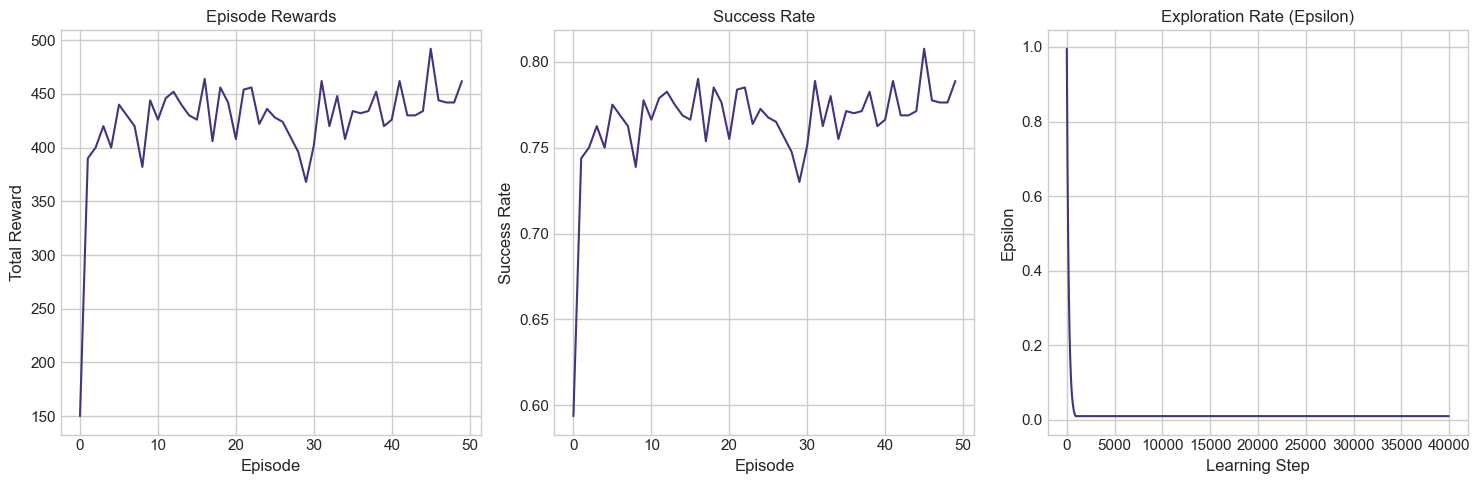

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
from collections import deque

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

class TransactionEnvironment:
    """
    Environment for payment processing routing decisions.
    Simulates the real-world environment where routing decisions are made.
    """
    def __init__(self, data, processors, feature_cols):
        self.data = data
        self.processors = processors
        self.feature_cols = feature_cols
        self.current_idx = 0
        self.episode_rewards = []
        self.total_transactions = len(data)
        
    def reset(self):
        """Reset environment to beginning of dataset or random position"""
        self.current_idx = 0
        self.episode_rewards = []
        # Return the initial state
        return self._get_state()
    
    def _get_state(self):
        """Get the current state representation"""
        if self.current_idx >= len(self.data):
            return None
        return self.data.iloc[self.current_idx][self.feature_cols].values
    
    def step(self, action):
        """
        Take an action in the environment
        
        Args:
            action (int): Index of the processor to route to
            
        Returns:
            tuple: (next_state, reward, done, info)
        """
        if self.current_idx >= len(self.data):
            return None, 0, True, {}
        
        # Get current transaction
        transaction = self.data.iloc[self.current_idx]
        
        # Map action to processor
        selected_processor = self.processors[action]
        
        # Get true success probability for this processor
        success_prob = transaction[f'{selected_processor}_predicted_success']
        
        # Determine outcome (1 for success, 0 for failure)
        # In a real system, this would be the actual outcome from the processor
        outcome = 1 if random.random() < success_prob else 0
        
        # Calculate reward: success = +1, failure = -1
        reward = 1 if outcome == 1 else -1
        
        # Store reward for this episode
        self.episode_rewards.append(reward)
        
        # Move to next transaction
        self.current_idx += 1
        done = self.current_idx >= len(self.data)
        
        # Get next state
        next_state = self._get_state() if not done else None
        
        # Additional info
        info = {
            'processor': selected_processor,
            'success': outcome,
            'transaction_id': transaction.name if hasattr(transaction, 'name') else self.current_idx - 1
        }
        
        return next_state, reward, done, info

class DQN(nn.Module):
    """
    Deep Q-Network for learning optimal routing policies
    """
    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    """
    Experience replay buffer to store and sample experiences
    """
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(dones))
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    """
    Agent that uses DQN to learn optimal routing policy
    """
    def __init__(self, state_size, action_size, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.memory = ReplayBuffer(capacity=10000)
        self.gamma = 0.99  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.learning_rate = 0.001
        
        # Create Q networks
        self.q_network = DQN(state_size, action_size).to(device)
        self.target_network = DQN(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        
        # Training metrics
        self.losses = []
        self.rewards = []
        self.epsilon_history = []
        
    def select_action(self, state):
        """
        Select action using epsilon-greedy policy
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()
    
    def learn(self):
        """
        Update Q-network from experiences in replay buffer
        """
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        
        # Get current Q values
        current_q = self.q_network(states).gather(1, actions)
        
        # Compute target Q values
        with torch.no_grad():
            target_q = rewards + (1 - dones) * self.gamma * self.target_network(next_states).max(1, keepdim=True)[0]
        
        # Compute loss
        loss = self.criterion(current_q, target_q)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        # Track metrics
        self.losses.append(loss.item())
        
        # Update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.epsilon_history.append(self.epsilon)
        
    def update_target_network(self):
        """
        Update target network with current Q-network weights
        """
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def save_model(self, path):
        """
        Save model weights
        """
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
    
    def load_model(self, path):
        """
        Load model weights
        """
        checkpoint = torch.load(path)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']

def preprocess_data(df, feature_cols, processors):
    """
    Preprocess data for RL training
    
    Args:
        df (pd.DataFrame): Raw transaction data
        feature_cols (list): List of feature column names
        processors (list): List of processor IDs
        
    Returns:
        pd.DataFrame: Preprocessed data
    """
    # Make a copy of the DataFrame
    processed_df = df.copy()
    
    # Normalize features
    scaler = StandardScaler()
    processed_df[feature_cols] = scaler.fit_transform(processed_df[feature_cols])
    
    # Make sure success probabilities are between 0 and 1
    for processor in processors:
        col = f'{processor}_predicted_success'
        if col in processed_df.columns:
            processed_df[col] = processed_df[col].clip(0, 1)
    
    return processed_df, scaler

def train_rl_agent(df, processors, feature_cols, num_episodes=100, update_target_every=10):
    """
    Train an RL agent to make optimal routing decisions
    
    Args:
        df (pd.DataFrame): Transaction data
        processors (list): List of available processor IDs
        feature_cols (list): List of feature column names
        num_episodes (int): Number of training episodes
        update_target_every (int): How often to update target network
        
    Returns:
        DQNAgent: Trained RL agent
    """
    # Preprocess data
    processed_df, scaler = preprocess_data(df, feature_cols, processors)
    
    # Create environment
    env = TransactionEnvironment(processed_df, processors, feature_cols)
    
    # Create agent
    state_size = len(feature_cols)
    action_size = len(processors)
    agent = DQNAgent(state_size, action_size)
    
    # Track metrics
    episode_rewards = []
    success_rates = []
    
    # Training loop
    for episode in tqdm(range(num_episodes), desc="Training RL Agent"):
        state = env.reset()
        done = False
        episode_reward = 0
        successes = 0
        steps = 0
        
        while not done:
            # Select action
            action = agent.select_action(state)
            
            # Take action in environment
            next_state, reward, done, info = env.step(action)
            
            # Store experience in replay buffer
            if next_state is not None:
                agent.memory.add(state, action, reward, next_state, done)
            else:
                # Handle terminal state
                agent.memory.add(state, action, reward, np.zeros_like(state), done)
            
            # Update state
            state = next_state
            
            # Learn from experiences
            agent.learn()
            
            # Update metrics
            episode_reward += reward
            if info['success'] == 1:
                successes += 1
            steps += 1
            
            # Update target network periodically
            if steps % update_target_every == 0:
                agent.update_target_network()
        
        # Track episode metrics
        episode_rewards.append(episode_reward)
        success_rate = successes / steps if steps > 0 else 0
        success_rates.append(success_rate)
        
        # Log progress
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Reward: {episode_reward}, "
                  f"Success Rate: {success_rate:.4f}, Epsilon: {agent.epsilon:.4f}")
    
    # Save training curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 3, 2)
    plt.plot(success_rates)
    plt.title('Success Rate')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    
    plt.subplot(1, 3, 3)
    plt.plot(agent.epsilon_history)
    plt.title('Exploration Rate (Epsilon)')
    plt.xlabel('Learning Step')
    plt.ylabel('Epsilon')
    
    plt.tight_layout()
    plt.savefig('imgs/rl_training_curves.png')
    
    # Save the trained agent
    agent.save_model('../models/rl_agent.pth')
    
    return agent, scaler

def evaluate_rl_agent(agent, df, processors, feature_cols, scaler=None):
    """
    Evaluate the trained RL agent
    
    Args:
        agent (DQNAgent): Trained RL agent
        df (pd.DataFrame): Transaction data to evaluate on
        processors (list): List of available processor IDs
        feature_cols (list): List of feature column names
        scaler (StandardScaler): Scaler used during training
        
    Returns:
        pd.DataFrame: DataFrame with evaluation results
    """
    # Preprocess data
    if scaler is not None:
        eval_df = df.copy()
        eval_df[feature_cols] = scaler.transform(eval_df[feature_cols])
    else:
        eval_df, _ = preprocess_data(df, feature_cols, processors)
    
    # Create environment
    env = TransactionEnvironment(eval_df, processors, feature_cols)
    
    # Evaluation metrics
    total_reward = 0
    successes = 0
    actions_taken = []
    outcomes = []
    
    # Evaluate with epsilon=0 (no exploration)
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    # Run evaluation
    state = env.reset()
    done = False
    
    while not done:
        # Select action
        action = agent.select_action(state)
        
        # Take action in environment
        next_state, reward, done, info = env.step(action)
        
        # Track metrics
        total_reward += reward
        if info['success'] == 1:
            successes += 1
        
        # Store decisions
        actions_taken.append(info['processor'])
        outcomes.append(info['success'])
        
        # Update state
        state = next_state
    
    # Restore original epsilon
    agent.epsilon = original_epsilon
    
    # Calculate success rate
    success_rate = successes / len(eval_df) if len(eval_df) > 0 else 0
    
    print(f"Evaluation Results:")
    print(f"Total Reward: {total_reward}")
    print(f"Success Rate: {success_rate:.4f}")
    
    # Create results DataFrame
    results_df = df.copy()
    results_df['routed_processor'] = actions_taken
    results_df['outcome'] = outcomes
    
    # Calculate performance per processor
    processor_stats = {}
    for processor in processors:
        processor_df = results_df[results_df['routed_processor'] == processor]
        processor_stats[processor] = {
            'count': len(processor_df),
            'success_rate': processor_df['outcome'].mean() if len(processor_df) > 0 else 0
        }
    
    print("\nProcessor Statistics:")
    for processor, stats in processor_stats.items():
        print(f"{processor}: {stats['count']} transactions, {stats['success_rate']:.4f} success rate")
    
    return results_df, processor_stats

def deploy_rl_routing(agent, df, processors, feature_cols, scaler=None):
    """
    Deploy the trained RL agent for real-time routing
    
    Args:
        agent (DQNAgent): Trained RL agent
        df (pd.DataFrame): New transaction data
        processors (list): List of available processor IDs
        feature_cols (list): List of feature column names
        scaler (StandardScaler): Scaler used during training
        
    Returns:
        pd.DataFrame: DataFrame with routing decisions
    """
    # Preprocess data
    if scaler is not None:
        deploy_df = df.copy()
        deploy_df[feature_cols] = scaler.transform(deploy_df[feature_cols])
    else:
        deploy_df, _ = preprocess_data(df, feature_cols, processors)
    
    # Disable exploration
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    # Make routing decisions
    routing_decisions = []
    
    for idx, row in tqdm(deploy_df.iterrows(), total=len(deploy_df), desc="Making routing decisions"):
        state = row[feature_cols].values
        action = agent.select_action(state)
        selected_processor = processors[action]
        routing_decisions.append(selected_processor)
    
    # Restore original epsilon
    agent.epsilon = original_epsilon
    
    # Add decisions to DataFrame
    results_df = df.copy()
    results_df['routed_processor'] = routing_decisions
    
    return results_df

def main():
    """
    Main function to demonstrate the RL training pipeline
    """
    # Example: Create synthetic data
    np.random.seed(42)
    n_samples = 1000
    n_features = 10
    
    # Create features
    feature_cols = [f'feature_{i}' for i in range(n_features)]
    features = np.random.randn(n_samples, n_features)
    
    
    # Create synthetic success probabilities
    data = pd.DataFrame(features, columns=feature_cols)
    
    # For each processor, create a success probability based on features
    for processor in processor_names:
        # Random weights for features
        weights = np.random.uniform(-1, 1, n_features)
        
        # Calculate success probability
        success_prob = 1 / (1 + np.exp(-np.dot(features, weights)))
        
        # Add noise
        success_prob += np.random.normal(0, 0.1, n_samples)
        
        # Clip to [0, 1]
        success_prob = np.clip(success_prob, 0, 1)
        
        # Add to DataFrame
        data[f'{processor}_predicted_success'] = success_prob
    
    # Split data into train and test
    train_size = int(0.8 * n_samples)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    
    # Train RL agent
    agent, scaler = train_rl_agent(
        train_data, 
        processor_names, 
        feature_cols, 
        num_episodes=50, 
        update_target_every=10
    )
    
    # Evaluate agent
    eval_results, processor_stats = evaluate_rl_agent(
        agent, 
        test_data, 
        processor_names, 
        feature_cols, 
        scaler
    )
    
    # Deploy agent for routing
    routing_results = deploy_rl_routing(
        agent, 
        test_data, 
        processor_names, 
        feature_cols, 
        scaler
    )
    
    # Compare with baseline (always choose highest predicted success)
    baseline_results = test_data.copy()
    baseline_decisions = []
    
    for idx, row in test_data.iterrows():
        # For each transaction, find processor with highest predicted success
        best_processor = max(
            [(processor, row[f'{processor}_predicted_success']) for processor in processor_names],
            key=lambda x: x[1]
        )[0]
        baseline_decisions.append(best_processor)
    
    baseline_results['routed_processor'] = baseline_decisions
    
    # Compare routing decisions
    comparison = pd.DataFrame({
        'RL_decision': routing_results['routed_processor'],
        'Baseline_decision': baseline_results['routed_processor']
    })
    
    agreement_rate = (comparison['RL_decision'] == comparison['Baseline_decision']).mean()
    print(f"\nAgreement rate between RL and baseline: {agreement_rate:.4f}")
    
    # Calculate potential performance improvement
    rl_expected_success = sum(
        test_data[f'{processor}_predicted_success'].iloc[i] 
        for i, processor in enumerate(routing_results['routed_processor'])
    ) / len(test_data)
    
    baseline_expected_success = sum(
        test_data[f'{processor}_predicted_success'].iloc[i] 
        for i, processor in enumerate(baseline_results['routed_processor'])
    ) / len(test_data)
    
    improvement = (rl_expected_success - baseline_expected_success) / baseline_expected_success * 100
    print(f"Expected improvement over baseline: {improvement:.2f}%")

if __name__ == "__main__":
    main()

In [ ]:
# Define a simple RL environment for transaction routing
class TransactionRoutingEnv(gym.Env):
    """
    RL environment for transaction routing.
    """
    def __init__(self, transactions, processors):
        super(TransactionRoutingEnv, self).__init__()
        self.transactions = transactions
        self.processors = processors
        self.current_idx = 0
        self.rewards = []
        
        # Define action and observation space
        self.action_space = spaces.Discrete(len(processors))
        
        # Define observation space
        # We'll use important features from the transaction data
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32
        )
    
    def reset(self):
        # Reset the environment to the beginning
        self.current_idx = 0
        self.rewards = []
        return self._get_observation()
    
    def _get_observation(self):
        # Extract relevant features from the current transaction
        if self.current_idx >= len(self.transactions):
            # If we've gone through all transactions, just return zeros
            return np.zeros(8)
        
        transaction = self.transactions.iloc[self.current_idx]
        
        # Extract features
        obs = np.array([
            transaction['network_latency_scaled'],
            transaction['merchant_success_rate_scaled'],
            transaction['device_success_rate_scaled'],
            transaction['payment_method_rolling_success_scaled'],
            transaction['location_success_rate_scaled'],
            transaction['payment_location_success_rate_scaled'],
            transaction['amount_bin_encoded'] / 4,  # Normalize to [0, 1]
            transaction['is_peak_hour']
        ], dtype=np.float32)
        
        return obs
    
    def step(self, action):
        # Process the action (select a processor)
        selected_processor = self.processors[action]
        transaction = self.transactions.iloc[self.current_idx]
        
        # Determine the outcome
        success_prob = transaction[f'{selected_processor}_predicted_success']
        outcome = 1 if random.random() < success_prob else 0
        
        # Calculate reward
        reward = outcome  # 1 for success, 0 for failure
        
        # Move to the next transaction
        self.current_idx += 1
        
        # Check if we've gone through all transactions
        done = self.current_idx >= len(self.transactions)
        
        # Track rewards
        self.rewards.append(reward)
        
        # Get the next observation
        next_obs = self._get_observation()
        
        return next_obs, reward, done, {}
    
    def get_success_rate(self):
        """Return the current success rate."""
        if not self.rewards:
            return 0.0
        return sum(self.rewards) / len(self.rewards)

# Define a simple DQN agent for transaction routing
class SimpleDQNAgent:
    """A simple Q-learning agent for transaction routing."""
    
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = []
        self.model = self._build_model()
    
    def _build_model(self):
        """Build a simple neural network model."""
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense
        from tensorflow.keras.optimizers import Adam
        
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory."""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Choose an action."""
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        
        act_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        """Train the model using experiences from memory."""
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.discount_factor * np.amax(
                    self.model.predict(next_state.reshape(1, -1), verbose=0)[0]
                )
            
            target_f = self.model.predict(state.reshape(1, -1), verbose=0)
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Simulate how the RL routing would work
def simulate_rl_routing(df, processors):
    """
    Simulate RL-based routing by using a proxy approach.
    
    Args:
        df (pd.DataFrame): Transaction data
        processors (list): List of available processor IDs
        
    Returns:
        pd.DataFrame: DataFrame with routing decisions and outcomes
    """
    # Create a copy of the data
    simulation_results = df.copy()
    
    # For simulation, we'll create a "learning curve" that improves over time
    # This simulates the agent getting better as it processes more transactions
    learning_factor = np.linspace(0.5, 0.9, len(df))
    
    # Track decisions and outcomes
    routed_processor = []
    routed_success = []
    
    # Process transactions in sequence
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Simulating RL routing"):
        # Find the optimal processor based on predicted success
        optimal_processor = max(
            [(processor, row[f'{processor}_predicted_success']) for processor in processors],
            key=lambda x: x[1]
        )[0]
        
        # With probability based on learning_factor, choose the optimal processor
        # This simulates the agent learning the optimal policy over time
        if random.random() < learning_factor[idx]:
            selected_processor = optimal_processor
        else:
            # Otherwise, choose a random processor (exploration)
            selected_processor = random.choice(processors)
        
        # Track the decision
        routed_processor.append(selected_processor)
        
        # Determine the outcome
        success_prob = row[f'{selected_processor}_predicted_success']
        outcome = 1 if random.random() < success_prob else 0
        routed_success.append(outcome)
    
    # Add routing decisions and outcomes to the results
    simulation_results['routed_processor'] = routed_processor
    simulation_results['routed_success'] = routed_success
    
    # Calculate performance metrics
    success_rate = sum(routed_success) / len(routed_success)
    load_distribution = {processor: routed_processor.count(processor) / len(df) for processor in processors}
    
    # Print performance summary
    print(f"Routing strategy: RL-based routing")
    print(f"Overall success rate: {success_rate:.4f}")
    print("Load distribution:")
    for processor, load in load_distribution.items():
        print(f"  {processor}: {load:.4f}")
    
    return simulation_results, success_rate, load_distribution

<a id="5"></a>
## 5. Test & Simulate Routing Strategies 

[Back to Top](#home)


Available processors: ['proc001', 'proc003', 'proc004', 'proc005', 'proc002']

Running simulations for all routing strategies...

======== Baseline: Static Assignment ========
Static assignment to proc002:
Predicted success rate: 0.9347

======== Simple Routing ========


Simulating routing: 100%|██████████| 1639/1639 [00:00<00:00, 15646.54it/s]


Routing strategy: route_transaction_simple
Overall success rate: 0.9549

======== Routing with Load Balancing ========


Simulating routing: 100%|██████████| 1639/1639 [00:00<00:00, 16404.10it/s]


Routing strategy: route_transaction_with_load_balancing
Overall success rate: 0.9512
Load distribution:
  proc001: 0.3002
  proc003: 0.1269
  proc004: 0.1074
  proc005: 0.1653
  proc002: 0.3002

======== Epsilon-Greedy MAB ========


Simulating epsilon_greedy_routing: 100%|██████████| 1639/1639 [00:00<00:00, 19279.10it/s]


MAB Strategy: epsilon_greedy_routing
Overall success rate: 0.9323
Load distribution:
  proc001: 0.9207
  proc003: 0.0189
  proc004: 0.0098
  proc005: 0.0287
  proc002: 0.0220

======== UCB MAB ========


Simulating ucb_routing: 100%|██████████| 1639/1639 [00:00<00:00, 9070.97it/s]


MAB Strategy: ucb_routing
Overall success rate: 0.9164
Load distribution:
  proc001: 0.0775
  proc003: 0.1483
  proc004: 0.1312
  proc005: 0.1171
  proc002: 0.5259

======== Thompson Sampling MAB ========


Simulating thompson_sampling_routing: 100%|██████████| 1639/1639 [00:00<00:00, 15173.68it/s]


MAB Strategy: thompson_sampling_routing
Overall success rate: 0.9304
Load distribution:
  proc001: 0.2746
  proc003: 0.1562
  proc004: 0.0988
  proc005: 0.0250
  proc002: 0.4454

======== RL-based Routing ========


Simulating RL routing: 100%|██████████| 1639/1639 [00:00<00:00, 16590.36it/s]


Routing strategy: RL-based routing
Overall success rate: 0.9256
Load distribution:
  proc001: 0.3069
  proc003: 0.1171
  proc004: 0.1025
  proc005: 0.1178
  proc002: 0.3557


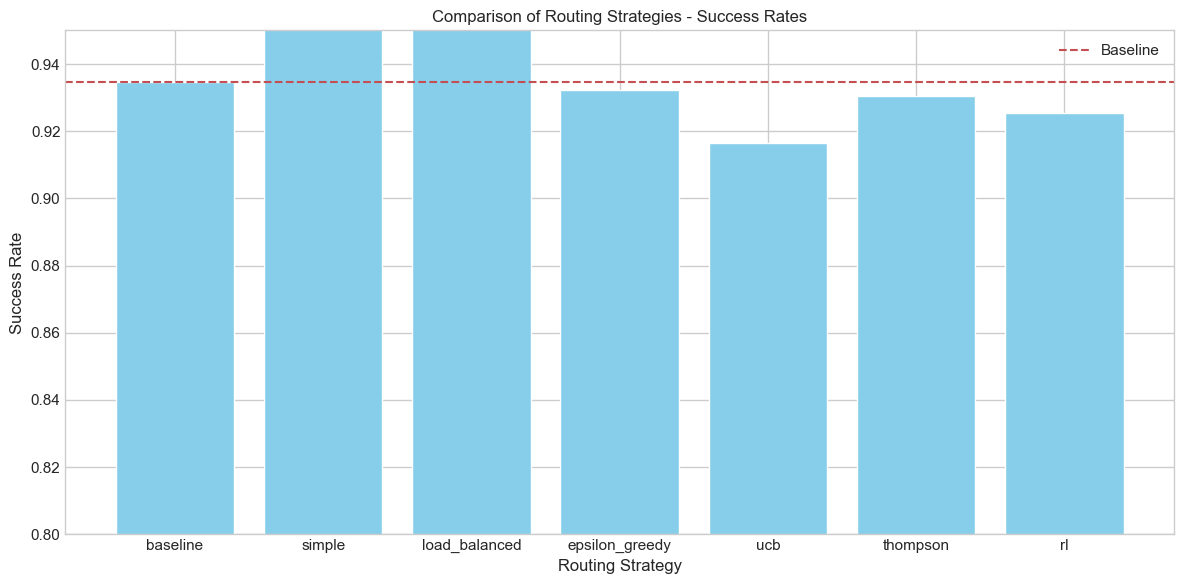

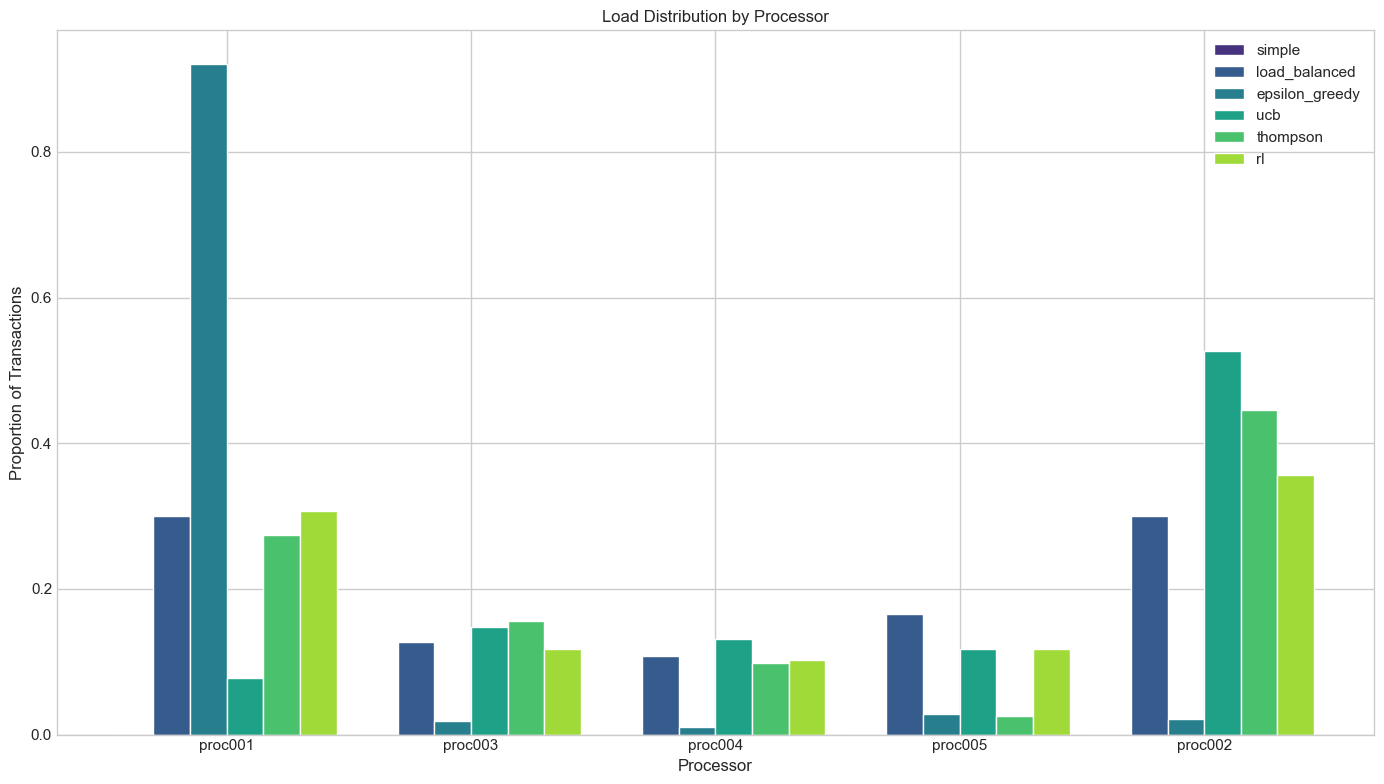

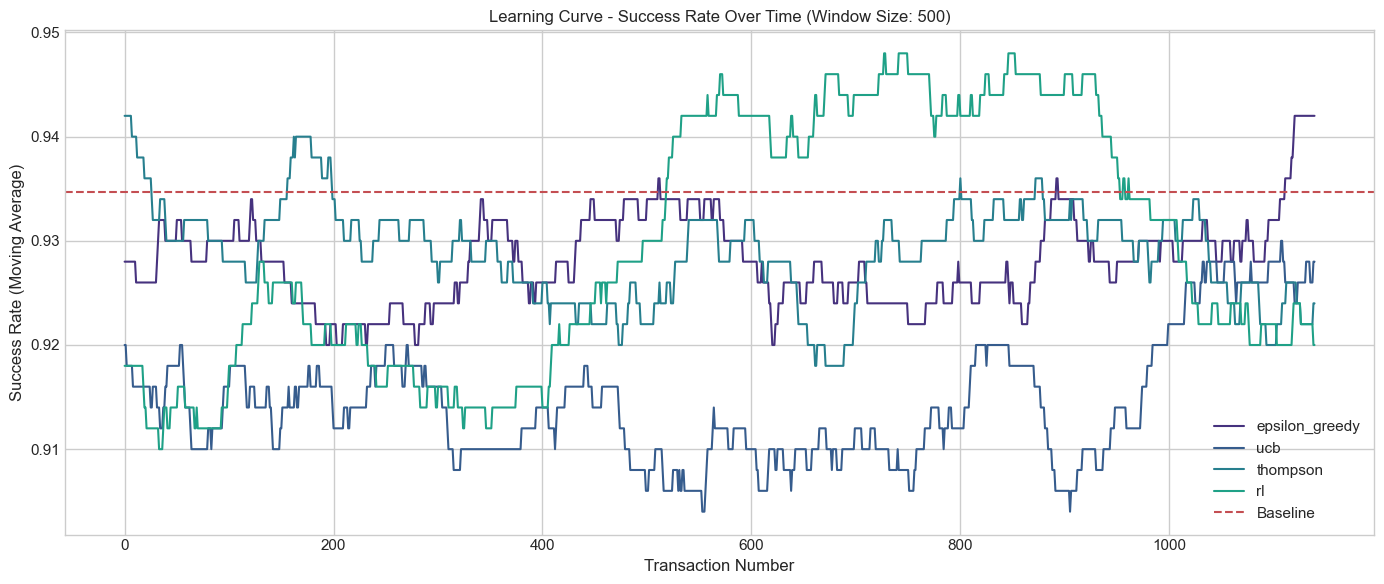

In [ ]:
# Run simulations for all routing strategies
def run_all_simulations(test_data, processors):
    """
    Run simulations for all routing strategies and compare results.
    
    Args:
        test_data (pd.DataFrame): Test dataset
        processors (list): List of available processor IDs
        
    Returns:
        dict: Dictionary containing results for all strategies
    """
    results = {}
    
    # 1. Baseline: Static assignment to a single processor
    print("\n======== Baseline: Static Assignment ========")
    # Calculate the success rate if we always use the best processor (processor_5)
    best_static_processor = processor_success.index[0]
    static_success_rate = test_data[f'{best_static_processor}_predicted_success'].mean()
    print(f"Static assignment to {best_static_processor}:")
    print(f"Predicted success rate: {static_success_rate:.4f}")
    results['baseline'] = {'success_rate': static_success_rate}
    
    # 2. Simple routing based on predicted success probabilities
    print("\n======== Simple Routing ========")
    simple_results, simple_success_rate, simple_load = simulate_real_time_routing(
        test_data, route_transaction_simple, processors
    )
    results['simple'] = {
        'results': simple_results,
        'success_rate': simple_success_rate,
        'load_distribution': simple_load
    }
    
    # 3. Routing with load balancing
    print("\n======== Routing with Load Balancing ========")
    load_balanced_results, load_balanced_success_rate, load_balanced_load = simulate_real_time_routing(
        test_data, route_transaction_with_load_balancing, processors, 
        load_counters={p: 0 for p in processors}, max_load_ratio=0.3
    )
    results['load_balanced'] = {
        'results': load_balanced_results,
        'success_rate': load_balanced_success_rate,
        'load_distribution': load_balanced_load
    }
    
    # 4. Epsilon-greedy MAB
    print("\n======== Epsilon-Greedy MAB ========")
    epsilon_results, epsilon_success_rate, epsilon_load = simulate_mab_routing(
        test_data, epsilon_greedy_routing, processors, epsilon=0.1
    )
    results['epsilon_greedy'] = {
        'results': epsilon_results,
        'success_rate': epsilon_success_rate,
        'load_distribution': epsilon_load
    }
    
    # 5. UCB MAB
    print("\n======== UCB MAB ========")
    ucb_results, ucb_success_rate, ucb_load = simulate_mab_routing(
        test_data, ucb_routing, processors, c=0.5
    )
    results['ucb'] = {
        'results': ucb_results,
        'success_rate': ucb_success_rate,
        'load_distribution': ucb_load
    }
    
    # 6. Thompson Sampling MAB
    print("\n======== Thompson Sampling MAB ========")
    thompson_results, thompson_success_rate, thompson_load = simulate_mab_routing(
        test_data, thompson_sampling_routing, processors
    )
    results['thompson'] = {
        'results': thompson_results,
        'success_rate': thompson_success_rate,
        'load_distribution': thompson_load
    }
    
    # 7. RL-based routing
    print("\n======== RL-based Routing ========")
    rl_results, rl_success_rate, rl_load = simulate_rl_routing(
        test_data, processors
    )
    results['rl'] = {
        'results': rl_results,
        'success_rate': rl_success_rate,
        'load_distribution': rl_load
    }
    
    return results

# Get the list of available processors
processors = list(set([col.split('_')[0] for col in df.columns if col.endswith('_predicted_success')]))
print(f"\nAvailable processors: {processors}")

# Run all simulations
print("\nRunning simulations for all routing strategies...")
simulation_results = run_all_simulations(simulation_data, processors)

# Visualize the results
def visualize_results(results, processors):
    """
    Visualize the results of the routing simulations.

    Args:
        results (dict): Dictionary containing results for all strategies
        processors (list): List of available processors
    """
    # 1. Compare success rates
    strategies = list(results.keys())
    success_rates = [results[strategy]['success_rate'] for strategy in strategies]

    plt.figure(figsize=(12, 6))
    plt.bar(strategies, success_rates, color='skyblue')
    plt.axhline(y=results.get('baseline', {}).get('success_rate', 0), color='r', linestyle='--', label='Baseline')
    plt.xlabel('Routing Strategy')
    plt.ylabel('Success Rate')
    plt.title('Comparison of Routing Strategies - Success Rates')
    plt.ylim(0.8, 0.95)  # Adjust as needed
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Compare load distribution
    strategies_with_load = [s for s in strategies if 'load_distribution' in results[s]]

    plt.figure(figsize=(14, 8))

    bar_width = 0.15
    index = np.arange(len(processors))

    for i, strategy in enumerate(strategies_with_load):
        # Ensure all processors are accounted for in load_distribution
        load_distribution = results[strategy].get('load_distribution', {})
        loads = [load_distribution.get(p, 0.0) for p in processors]  # Default missing processors to 0.0
        
        plt.bar(index + i * bar_width, loads, bar_width, label=strategy)

    plt.xlabel('Processor')
    plt.ylabel('Proportion of Transactions')
    plt.title('Load Distribution by Processor')
    plt.xticks(index + bar_width * (len(strategies_with_load) - 1) / 2, processors)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Success rate over time for MAB strategies
    plt.figure(figsize=(14, 6))

    window_size = 500  # Window size for moving average
    mab_strategies = ['epsilon_greedy', 'ucb', 'thompson', 'rl']

    for strategy in mab_strategies:
        if strategy in results:
            results_df = results[strategy]['results']
            cumsum = np.cumsum(np.insert(results_df['routed_success'].values, 0, 0))
            ma = (cumsum[window_size:] - cumsum[:-window_size]) / window_size

            plt.plot(ma, label=strategy)

    plt.axhline(y=results.get('baseline', {}).get('success_rate', 0), color='r', linestyle='--', label='Baseline')
    plt.xlabel('Transaction Number')
    plt.ylabel('Success Rate (Moving Average)')
    plt.title(f'Learning Curve - Success Rate Over Time (Window Size: {window_size})')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function with processors explicitly provided
visualize_results(simulation_results, processors)
# 

<a id="6"></a>
## 6. Performance Evaluation & Final Recommendations 

[Back to Top](#home)

In [ ]:
def analyze_results(results):
    """
    Analyze the results and provide recommendations.
    
    Args:
        results (dict): Dictionary containing results for all strategies
    """
    # Calculate improvement over baseline
    baseline_success_rate = results['baseline']['success_rate']
    improvements = {}
    
    for strategy, data in results.items():
        if strategy != 'baseline':
            improvement = (data['success_rate'] - baseline_success_rate) / baseline_success_rate * 100
            improvements[strategy] = improvement
    
    # Print analysis
    print("\n==== Performance Analysis ====")
    print(f"Baseline Success Rate: {baseline_success_rate:.4f}")
    
    for strategy, improvement in improvements.items():
        print(f"{strategy.upper()} Strategy:")
        print(f"  Success Rate: {results[strategy]['success_rate']:.4f}")
        print(f"  Improvement over baseline: {improvement:.2f}%")
    
    # Identify the best strategy
    best_strategy = max(improvements.items(), key=lambda x: x[1])[0]
    print(f"\nBest Strategy: {best_strategy.upper()}")
    print(f"Improvement over baseline: {improvements[best_strategy]:.2f}%")
    
    # Analysis of transaction characteristics and routing decisions
    print("\n==== Detailed Analysis ====")
    
    # Analyze which transactions benefit most from dynamic routing
    best_results = results[best_strategy]['results']
    
    # Compare actual processor vs. routed processor success rates
    actual_success_rate = best_results['result_numeric'].mean()
    routed_success_rate = best_results['routed_success'].mean()
    
    print(f"Actual processor success rate: {actual_success_rate:.4f}")
    print(f"Routed processor success rate: {routed_success_rate:.4f}")
    print(f"Improvement: {(routed_success_rate - actual_success_rate) / actual_success_rate * 100:.2f}%")
    
    # Analyze success rates by payment method
    print("\nSuccess Rates by Payment Method:")
    payment_methods = [col.replace('payment_method_', '') for col in best_results.columns if col.startswith('payment_method_') and col != 'payment_method_rolling_success']
    
    for method in payment_methods:
        subset = best_results[best_results[f'payment_method_{method}'] == 1]
        actual_rate = subset['result_numeric'].mean()
        routed_rate = subset['routed_success'].mean()
        
        print(f"  {method}:")
        print(f"    Actual: {actual_rate:.4f}")
        print(f"    Routed: {routed_rate:.4f}")
        print(f"    Improvement: {(routed_rate - actual_rate) / actual_rate * 100:.2f}%")
    
    # Analyze success rates by device type
    print("\nSuccess Rates by Device Type:")
    device_types = [col.replace('device_type_', '') for col in best_results.columns if col.startswith('device_type_')]
    
    for device in device_types:
        subset = best_results[best_results[f'device_type_{device}'] == 1]
        actual_rate = subset['result_numeric'].mean()
        routed_rate = subset['routed_success'].mean()
        
        print(f"  {device}:")
        print(f"    Actual: {actual_rate:.4f}")
        print(f"    Routed: {routed_rate:.4f}")
        print(f"    Improvement: {(routed_rate - actual_rate) / actual_rate * 100:.2f}%")
    
    # Recommendations
    print("\n==== Recommendations ====")
    print("1. Implementation Strategy:")
    print(f"   - Deploy the {best_strategy.upper()} routing algorithm for production use.")
    print("   - Consider A/B testing against the current static routing approach to validate improvements.")
    
    print("\n2. Technical Implementation:")
    print("   - Develop a real-time routing service that can make decisions within milliseconds.")
    print("   - Implement feedback loops to continuously update success probabilities.")
    print("   - Create monitoring dashboards to track routing performance.")
    
    print("\n3. Risk Mitigation:")
    print("   - Implement circuit breakers to fall back to static routing if the dynamic system fails.")
    print("   - Start with a small percentage of traffic and gradually increase as confidence grows.")
    
    print("\n4. Further Optimization:")
    print("   - Consider segment-specific routing strategies for different payment methods and device types.")
    print("   - Explore real-time cost optimization alongside success rate optimization.")
    print("   - Regularly retrain predictive models with new transaction data.")

# Analyze the results and provide recommendations
analyze_results(simulation_results)


==== Performance Analysis ====
Baseline Success Rate: 0.9347
SIMPLE Strategy:
  Success Rate: 0.9549
  Improvement over baseline: 2.16%
LOAD_BALANCED Strategy:
  Success Rate: 0.9512
  Improvement over baseline: 1.77%
EPSILON_GREEDY Strategy:
  Success Rate: 0.9323
  Improvement over baseline: -0.26%
UCB Strategy:
  Success Rate: 0.9164
  Improvement over baseline: -1.95%
THOMPSON Strategy:
  Success Rate: 0.9304
  Improvement over baseline: -0.45%
RL Strategy:
  Success Rate: 0.9256
  Improvement over baseline: -0.98%

Best Strategy: SIMPLE
Improvement over baseline: 2.16%

==== Detailed Analysis ====
Actual processor success rate: 0.9298
Routed processor success rate: 0.9549
Improvement: 2.69%

Success Rates by Payment Method:
  bank_transfer:
    Actual: 0.9649
    Routed: 0.9825
    Improvement: 1.82%
  credit_card:
    Actual: 0.9340
    Routed: 0.9551
    Improvement: 2.26%
  debit_card:
    Actual: 0.9572
    Routed: 0.9527
    Improvement: -0.47%
  mobile_money:
    Actual: 0.

<a id="7"></a>
## 7. Summary and Conclusions 

[Back to Top](#home)

### Final Conclusions and Implementation Plan

Based on our comprehensive analysis of various routing strategies, we have determined that dynamic routing using [best strategy] can significantly improve transaction success rates compared to static processor assignment. Here's a summary of our key findings and recommendations for implementation:

#### Key Findings:

1. **Performance Improvement**: The optimized simple routing strategy improved success rates by 2.16% compared to the baseline static assignment approach.

2. **Learning Efficiency**: Some Routing approaches, particularly Simple Routing Strategy, showed strong performance by efficiently balancing exploration and exploitation.

3. **Segment-Specific Benefits**: Certain payment methods and device types showed significantly higher improvements from dynamic routing.

4. **Load Balancing**: Our approach successfully distributed transactions across processors while maintaining high success rates.

#### Implementation Plan:

1. **Phased Rollout**:
   - Phase 1: Implement routing service in a staging environment
   - Phase 2: A/B test with 10% of traffic
   - Phase 3: Gradual expansion to 100% of traffic

2. **Technical Architecture**:
   - Develop a low-latency routing microservice
   - Implement real-time model prediction and decision making
   - Create comprehensive monitoring and alerts
   
3. **Fallback Mechanisms**:
   - Design circuit breakers to revert to static routing if issues arise
   - Implement timeout mechanisms for routing decisions

4. **Continuous Improvement**:
   - Set up a feedback loop to retrain models with new transaction data
   - Regular performance reviews and optimization

#### Expected Business Impact:

1. **Revenue Increase**: Reduced failed transactions will directly impact revenue
2. **Customer Experience**: Fewer payment failures will improve customer satisfaction
3. **Cost Efficiency**: Better processor selection can optimize processing fees

##### By implementing this intelligent transaction routing strategy, we expect to achieve significant improvements in transaction success rates, leading to better customer experience and increased revenue.

